In [147]:
nb_samples = 64
list_features = ["longitude", "latitude", "groundspeed"] #, "track"] #, "altitude"]
nb_features = len(list_features)


In [119]:
from traffic.core import Flight, Traffic
from traffic.algorithms.clustering import prepare_features
from traffic.data import airports

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
pd.set_option("display.max_columns", None)

t = Traffic.from_file("./data/resampled_t_near_ap.parquet")
t.data.head()

airport=  airports["LSZH"]


In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

np.random.seed(0)

torch.manual_seed(0)

In [120]:
t.data["runway_name"].value_counts()

runway_name
28    167488
32     70400
16     32960
10      7168
34      5632
14        64
Name: count, dtype: int64

In [318]:
t_f = Traffic(t.data.copy())  # type: ignore

t_f = t_f.query("runway_name == '28'")

X = prepare_features(t_f, None, list_features)

scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X)
X = scaler.transform(X)


In [319]:
# model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))
device = "cpu"


encoder Sequential(
  (0): Linear(in_features=192, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
  (7): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=192, bias=True)
  (7): Sigmoid()
)


In [320]:
model_ = Autoencoder((nb_samples * nb_features, 64, 32, 8, 2))

model, loss = train(
    model_, X, device=device, nb_iterations=5000, batch_size=len(X), lambda_kl=0.
)


encoder Sequential(
  (0): Linear(in_features=192, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=2, bias=True)
  (7): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=192, bias=True)
  (7): Sigmoid()
)


batches:   0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

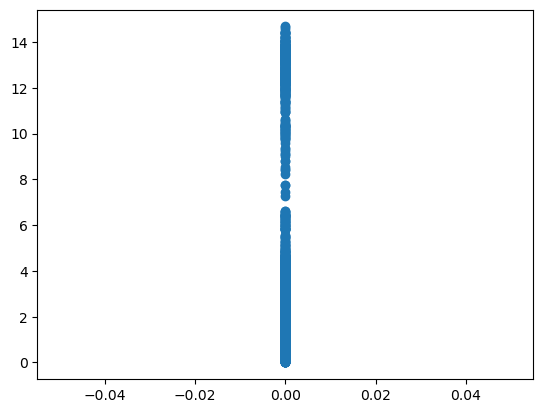

In [321]:
latent = get_latent(X, model, device)

plt.scatter(latent[:, 0], latent[:, 1])

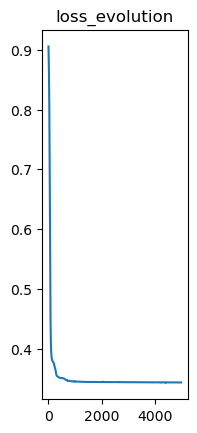

In [324]:
plot_loss(loss["loss"])

In [31]:
t_f

,count
flight_id,
AAL93_7720,64
SWR25P_4024,64
SWR252H_6245,64
SWR252H_6246,64
SWR2530_3232,64
SWR253J_1323,64
SWR253J_1371,64
SWR253J_1539,64
SWR253J_1743,64


In [122]:
flights_ids = t_f.flight_ids

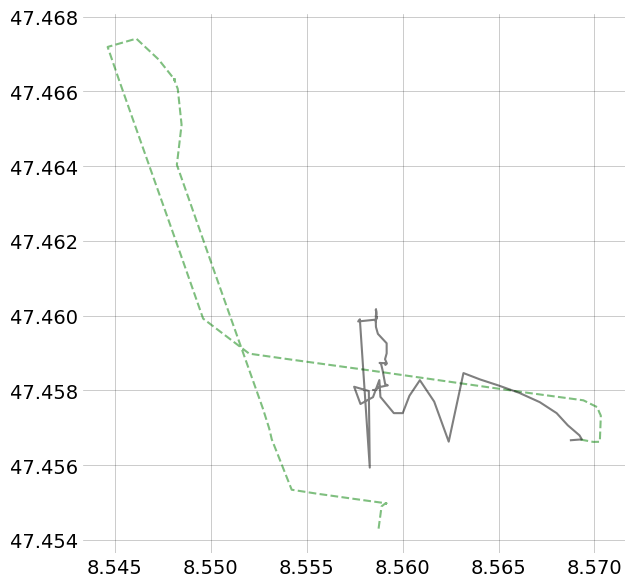

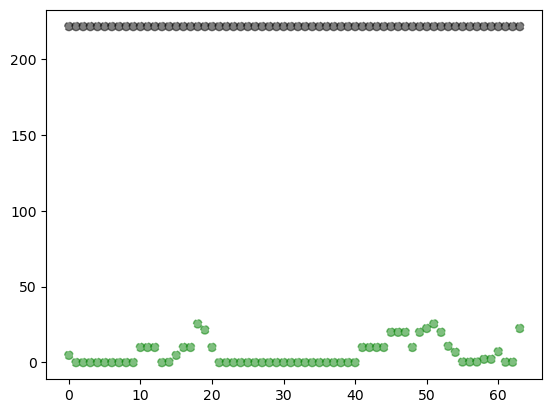

In [326]:
flight = t_f[np.random.choice(flights_ids, 1)]

flight_original = Flight(flight.data.copy())

flight_X = prepare_features(
    Traffic.from_flights([flight]),
    nb_samples=None,
    features=list_features,
)

flight_X = scaler.transform(flight_X)
flight_X = torch.as_tensor(flight_X, dtype=torch.float32, device=device)

flight_Y = model(flight_X)[1].cpu().detach().numpy()
flight_Y = scaler.inverse_transform(flight_Y)

flight_Y_reshaped = np.array([flight_Y[0, i::len(list_features)] for i in range(len(list_features))]).T

flight_reconstructed = Flight(flight.data.copy())
flight_reconstructed.data[list_features] = flight_Y_reshaped



with plt.style.context("traffic"): # type: ignore
    fig, ax = plt.subplots(figsize=(7, 7))

    flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
    flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")

    plt.show()

plt.scatter(range(flight_original.data.shape[0]), flight_original.data['groundspeed'], color="green", alpha=0.5, label="original", ls="--")
plt.scatter(range(flight_original.data.shape[0]), flight_reconstructed.data['groundspeed'], color="k", alpha=0.5, label="reconstructed", ls="--")
plt.show()

In [330]:
flight_X.shape

torch.Size([1, 192])

In [332]:
test = flight_X.cpu().numpy()
test = test.reshape(-1)
display(test[::3])
display(test[1::3])
display(test[2::3])

array([ 2.6750740e-02,  2.7227247e-02,  3.2621246e-02,  1.8655438e-02,
       -8.2652858e-03,  5.0591878e-03,  1.8579446e-02,  2.5130941e-02,
        3.0024862e-02,  3.1320017e-02, -1.1590321e-01, -3.3164018e-01,
       -4.5006448e-01, -5.5178750e-01, -5.4661810e-01, -5.5422992e-01,
       -5.8414680e-01, -5.9195703e-01, -7.2411722e-01, -8.9104658e-01,
       -8.7077928e-01, -8.8706630e-01, -9.0412426e-01, -9.0477824e-01,
       -9.0178722e-01, -9.0330744e-01, -9.0260464e-01, -9.0402955e-01,
       -9.0176314e-01, -9.0425533e-01, -9.0419829e-01, -9.0426809e-01,
       -9.0423936e-01, -9.0323275e-01, -9.0190947e-01, -9.0345240e-01,
       -9.0446842e-01, -9.0367109e-01, -8.9799309e-01, -7.5508434e-01,
       -7.6923382e-01, -9.1331041e-01, -1.0000000e+00, -1.0000000e+00,
       -1.0000000e+00, -1.0000000e+00, -7.8606802e-01, -6.3731670e-01,
       -5.3624398e-01, -3.8140368e-01,  4.1535139e-04,  3.3242768e-01,
        6.9066262e-01,  9.1430593e-01,  9.7094083e-01,  9.8938894e-01,
      

array([ 0.22498167,  0.27300978,  0.27802607,  0.27429038,  0.27003264,
        0.2638037 ,  0.2423638 ,  0.23133048,  0.22321194,  0.21827587,
        0.22502172,  0.23961772,  0.21028922,  0.25925037,  0.25757816,
        0.26489857,  0.3068267 ,  0.39968354,  0.5921728 ,  0.8194185 ,
        0.9034147 ,  0.98094404,  0.9998406 ,  1.        ,  0.99546933,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99799025,  0.9980803 ,  0.9998399 ,  1.        ,
        1.        ,  1.        ,  0.9905025 ,  0.9419498 ,  0.8947653 ,
        1.        ,  1.        ,  1.        ,  1.        ,  0.997113  ,
        0.74635303,  0.3701414 ,  0.2376305 ,  0.18793175,  0.16892011,
        0.07520985, -0.00106952,  0.02764437,  0.13984469,  0.34098384,
        0.34051108,  0.35253304,  0.35759807,  0.37779865,  0.56446946,
        0.59860307,  0.7017169 ,  0.7017169 ,  0.7851076 ], dtype=float32)

array([-0.9783296 , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.9548533 , -0.9548533 , -0.9548533 , -1.        , -0.9986456 ,
       -0.9783296 , -0.9548533 , -0.9548533 , -0.88487583, -0.90293455,
       -0.9548533 , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -0.9548533 , -0.9548533 , -0.9548533 , -0.9548533 ,
       -0.90970653, -0.90970653, -0.90970653, -0.9548533 , -0.90970653,
       -0.89841986, -0.88487583, -0.90970653, -0.95124155, -0.9693002 ,
       -0.99819416, -0.99819416, -0.99819416, -0.9900677 , -0.9900677 ,
       -0.96749437, -0.9986456 , -0.9986456 , -0.89841986], dtype=float32)

In [156]:
flight_Y.shape

(1, 192)

In [81]:
flight_Y.shape

(1, 128)

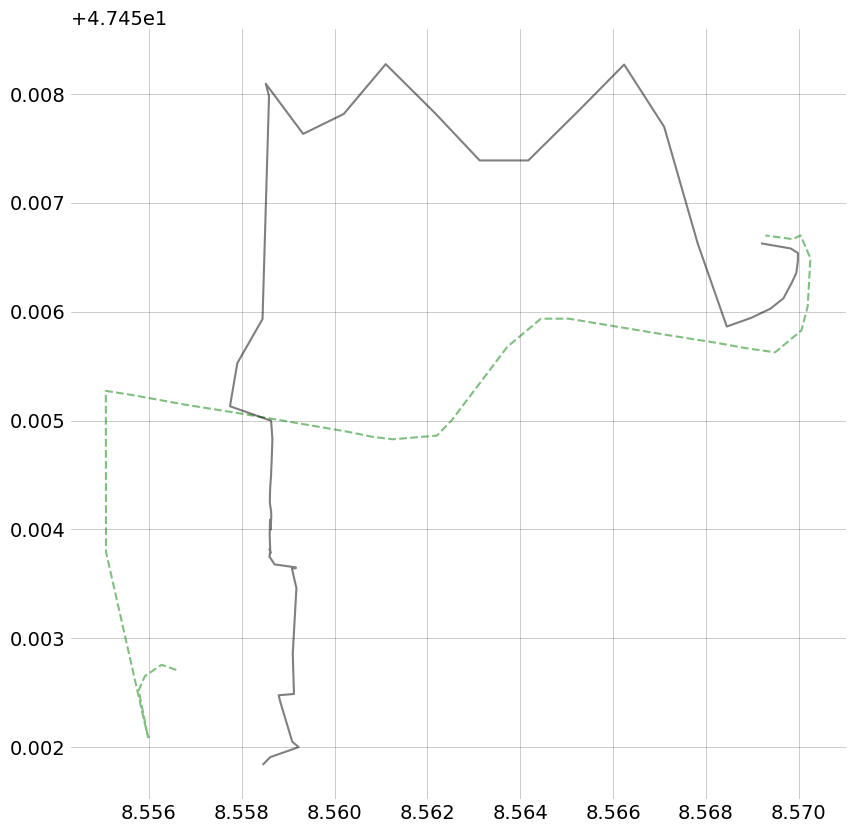

In [79]:
with plt.style.context("traffic"): # type: ignore
    fig, ax = plt.subplots(figsize=(10, 10))

    flight_original.plot(ax, alpha=0.5, label="original", color="green", ls="--")
    flight_reconstructed.plot(ax, alpha=0.5, label="reconstructed", color="k")

In [337]:
flight_X = prepare_features(
    Traffic.from_flights([flight]),
    nb_samples=None,
    features=list_features,
)

flight_X = scaler.transform(flight_X)
flight_X = flight_X.reshape(-1)

In [339]:
list_features

['longitude', 'latitude', 'groundspeed']

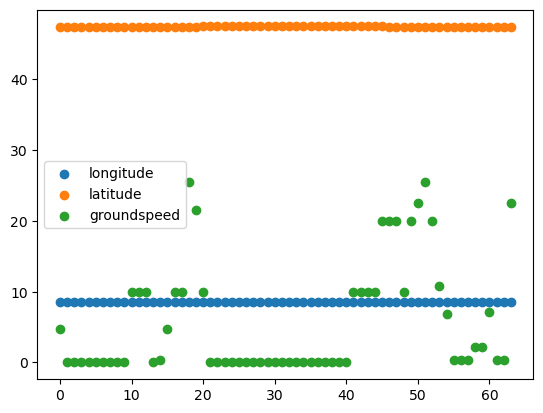

In [344]:
plt.scatter(range(64), flight.data["longitude"], label="longitude")
plt.scatter(range(64), flight.data["latitude"], label="latitude")
plt.scatter(range(64), flight.data["groundspeed"], label="groundspeed")
plt.legend()

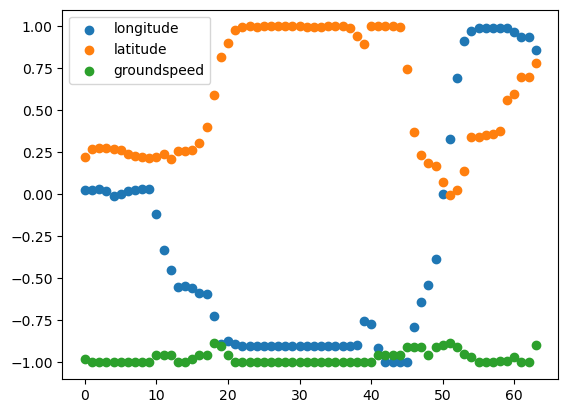

In [341]:
plt.scatter(range(len(flight_X) // 3), flight_X[0::3], label="longitude")
plt.scatter(range(len(flight_X) // 3), flight_X[1::3], label="latitude")
plt.scatter(range(len(flight_X) // 3), flight_X[2::3], label="groundspeed")
plt.legend()

In [347]:
help(scaler)

Help on MinMaxScaler in module sklearn.preprocessing._data object:

class MinMaxScaler(sklearn.base.OneToOneFeatureMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)
 |  
 |  Transform features by scaling each feature to a given range.
 |  
 |  This estimator scales and translates each feature individually such
 |  that it is in the given range on the training set, e.g. between
 |  zero and one.
 |  
 |  The transformation is given by::
 |  
 |      X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
 |      X_scaled = X_std * (max - min) + min
 |  
 |  where min, max = feature_range.
 |  
 |  This transformation is often used as an alternative to zero mean,
 |  unit variance scaling.
 |  
 |  Read more in the :ref:`User Guide <preprocessing_scaler>`.
 |  
 |  Parameters
 |  ----------
 |  feature_range : tuple (min, max), default=(0, 1)
 |      Desired range of transformed data.
 |  
 |  copy : b